<center>
    <h1>TME4</h1>
    <h5>Olivier RISSER-MAROIX</h5>
</center>

## 1. Lecture des données

In [1]:
import numpy as np
from math import *
from pylab import *

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

def read_file ( filename ):
    """
    Lit le fichier contenant les données du geyser Old Faithful
    """
    # lecture de l'en-tête
    infile = open ( filename, "r" )
    for ligne in infile:
        if ligne.find ( "eruptions waiting" ) != -1:
            break

    # ici, on a la liste des temps d'éruption et des délais d'irruptions
    data = []
    for ligne in infile:
        nb_ligne, eruption, waiting = [ float (x) for x in ligne.split () ]
        data.append ( eruption )
        data.append ( waiting )
    infile.close ()

    # transformation de la liste en tableau 2D
    data = np.asarray ( data )
    data.shape = ( int ( data.size / 2 ), 2 )

    return data

data = read_file ( "2015_tme4_faithful.txt" )

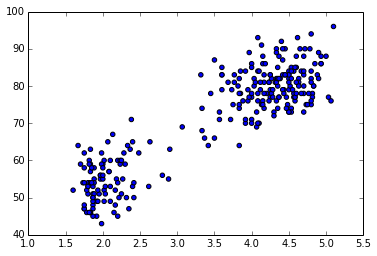

In [2]:
plt.scatter(*data.T)

## 2. Loi normale bidimensionnelle

In [3]:
def normale_bidim(x, z, q=None):
    mu_x, mu_z, sigma_x, sigma_z, ro = q
    #calcul de intermediaires par mesure de symplicite et d'efficacite
    c1 = (1 - ro ** 2)
    c2 = (x - mu_x)
    c3 = (z - mu_z)
    c4 = (c2 / sigma_x) ** 2
    c5 = (c3 / sigma_z) ** 2
    c6 = (sigma_x * sigma_z)
    c7 = -2 * ro * (c2 * c3) / c6
    return np.exp(-(c4 + c7 + c5) / (2 * c1)) / (2 * np.pi * c6 * c1 ** .5)

assert normale_bidim ( 1, 2, (1.0,2.0,3.0,4.0,0) )   == 0.013262911924324612
assert normale_bidim ( 1, 0, (1.0,2.0,1.0,2.0,0.7) ) == 0.041804799427614503

## 3. Visualisation de loi normale bidimensionnelle

In [4]:
import matplotlib.pyplot as plt

def dessine_1_normale ( params ):
    # récupération des paramètres
    mu_x, mu_z, sigma_x, sigma_z, rho = params

    # on détermine les coordonnées des coins de la figure
    x_min = mu_x - 2 * sigma_x
    x_max = mu_x + 2 * sigma_x
    z_min = mu_z - 2 * sigma_z
    z_max = mu_z + 2 * sigma_z

    # création de la grille
    x = np.linspace ( x_min, x_max, 100 )
    z = np.linspace ( z_min, z_max, 100 )
    X, Z = np.meshgrid(x, z)

    # calcul des normales
    norm = X.copy ()
    for i in range ( x.shape[0] ):
        for j in range ( z.shape[0] ):
            norm[i,j] = normale_bidim ( x[i], z[j], params )

    # affichage
    fig = plt.figure ()
    plt.contour ( X, Z, norm, cmap=cm.autumn )
    plt.show ()

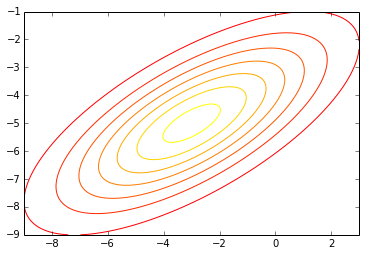

In [5]:
dessine_1_normale ( (-3.0,-5.0,3.0,2.0,0.7) )

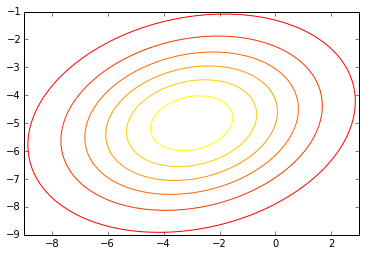

In [6]:
dessine_1_normale ( (-3.0,-5.0,3.0,2.0,0.2) )

## 4. Visualisation des données du Old Faithful

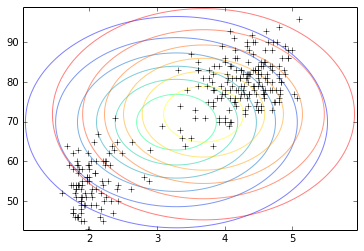

In [7]:
def dessine_normales ( data, params, weights, bounds, ax ):
    # récupération des paramètres
    mu_x0, mu_z0, sigma_x0, sigma_z0, rho0 = params[0]
    mu_x1, mu_z1, sigma_x1, sigma_z1, rho1 = params[1]

    # on détermine les coordonnées des coins de la figure
    x_min = bounds[0]
    x_max = bounds[1]
    z_min = bounds[2]
    z_max = bounds[3]

    # création de la grille
    nb_x = nb_z = 100
    x = np.linspace ( x_min, x_max, nb_x )
    z = np.linspace ( z_min, z_max, nb_z )
    X, Z = np.meshgrid(x, z)

    # calcul des normales
    norm0 = np.zeros ( (nb_x,nb_z) )
    for j in range ( nb_z ):
        for i in range ( nb_x ):
            norm0[j,i] = normale_bidim ( x[i], z[j], params[0] )# * weights[0]
    norm1 = np.zeros ( (nb_x,nb_z) )
    for j in range ( nb_z ):
        for i in range ( nb_x ):
             norm1[j,i] = normale_bidim ( x[i], z[j], params[1] )# * weights[1]

    # affichages des normales et des points du dataset
    ax.contour ( X, Z, norm0, cmap=cm.winter, alpha = 0.5 )
    ax.contour ( X, Z, norm1, cmap=cm.autumn, alpha = 0.5 )
    for point in data:
        ax.plot ( point[0], point[1], 'k+' )


def find_bounds ( data, params ):
    # récupération des paramètres
    mu_x0, mu_z0, sigma_x0, sigma_z0, rho0 = params[0]
    mu_x1, mu_z1, sigma_x1, sigma_z1, rho1 = params[1]

    # calcul des coins
    x_min = min ( mu_x0 - 2 * sigma_x0, mu_x1 - 2 * sigma_x1, data[:,0].min() )
    x_max = max ( mu_x0 + 2 * sigma_x0, mu_x1 + 2 * sigma_x1, data[:,0].max() )
    z_min = min ( mu_z0 - 2 * sigma_z0, mu_z1 - 2 * sigma_z1, data[:,1].min() )
    z_max = max ( mu_z0 + 2 * sigma_z0, mu_z1 + 2 * sigma_z1, data[:,1].max() )

    return ( x_min, x_max, z_min, z_max )


# affichage des données : calcul des moyennes et variances des 2 colonnes
mean1 = data[:,0].mean ()
mean2 = data[:,1].mean ()
std1  = data[:,0].std ()
std2  = data[:,1].std ()

# les paramètres des 2 normales sont autour de ces moyennes
params = np.array ( [(mean1 - 0.2, mean2 - 1, std1, std2, 0),
                     (mean1 + 0.2, mean2 + 1, std1, std2, 0)] )
weights = np.array ( [0.4, 0.6] )
bounds = find_bounds ( data, params )

# affichage de la figure
fig = plt.figure ()
ax = fig.add_subplot(111)
dessine_normales ( data, params, weights, bounds, ax )
plt.show ()

## 5. EM : l'étape E

In [8]:
def Q_i(data, current_params, pi):
    a_0 = pi[0] * normale_bidim(*data.T, q=current_params[0])
    a_1 = pi[1] * normale_bidim(*data.T, q=current_params[1])
    Q_i0 = a_0 / (a_0 + a_1)
    Q_i1 = a_1 / (a_0 + a_1)
    return np.array([Q_i0, Q_i1])

In [9]:
#current_params = np.array ( [(mu_x, mu_z, sigma_x, sigma_z, rho),   # params 1ère loi normale
#                             (mu_x, mu_z, sigma_x, sigma_z, rho)] ) # params 2ème loi normale
current_params = np.array([[ 3.28778309, 69.89705882, 1.13927121, 13.56996002, 0. ],
                           [ 3.68778309, 71.89705882, 1.13927121, 13.56996002, 0. ]])

# current_weights = np.array ( [ pi_0, pi_1 ] )
current_weights = np.array ( [ 0.5, 0.5 ] )

T = Q_i ( data, current_params, current_weights )

In [10]:
assert np.allclose(
    T[:, :9].T, 
    array([[ 0.46939088,  0.53060912],
        [ 0.66899936,  0.33100064],
        [ 0.50349992,  0.49650008],
        [ 0.61489199,  0.38510801],
        [ 0.38336517,  0.61663483],
        [ 0.58880845,  0.41119155],
        [ 0.36370054,  0.63629946],
        [ 0.45319835,  0.54680165],
        [ 0.66597113,  0.33402887]])
)

assert np.allclose(
    T[:, -6:].T,
    np.array([[ 0.3932781 ,  0.6067219 ],
        [ 0.42466754,  0.57533246],
        [ 0.66433838,  0.33566162],
        [ 0.3789881 ,  0.6210119 ],
        [ 0.68682391,  0.31317609],
        [ 0.41690852,  0.58309148]])
)

In [11]:
current_params = np.array([[ 3.2194684, 67.83748075, 1.16527301, 13.9245876,  0.9070348 ],
                           [ 3.75499261, 73.9440348, 1.04650191, 12.48307362, 0.88083712]])
current_weights = np.array ( [ 0.49896815, 0.50103185] )
T = Q_i ( data, current_params, current_weights )

In [12]:
assert np.allclose(
    T[:, :10].T,
    array([[ 0.44352868,  0.55647132],
        [ 0.70465534,  0.29534466],
        [ 0.47692866,  0.52307134],
        [ 0.61531052,  0.38468948],
        [ 0.38502072,  0.61497928],
        [ 0.58493721,  0.41506279],
        [ 0.37621272,  0.62378728],
        [ 0.42185109,  0.57814891],
        [ 0.70665534,  0.29334466],
        [ 0.39346396,  0.60653604]])
)

## 6. EM : l'étape M

In [13]:
def M_step(data, Q, current_params, current_weights):
    pi_0 = Q[0].sum() / Q.sum()
    pi_1 = Q[1].sum() / Q.sum()
    mu_x0 = (Q[0] * data.T[0]).sum() / Q[0].sum()
    mu_x1 = (Q[1] * data.T[0]).sum() / Q[1].sum()
    mu_z0 = (Q[0] * data.T[1]).sum() / Q[0].sum()
    mu_z1 = (Q[1] * data.T[1]).sum() / Q[1].sum()
    sigma_x0 = ((Q[0] * ((data.T[0] - mu_x0) ** 2)).sum() / Q[0].sum()) ** .5
    sigma_x1 = ((Q[1] * ((data.T[0] - mu_x1) ** 2)).sum() / Q[1].sum()) ** .5
    sigma_z0 = ((Q[0] * ((data.T[1] - mu_z0) ** 2)).sum() / Q[0].sum()) ** .5
    sigma_z1 = ((Q[1] * ((data.T[1] - mu_z1) ** 2)).sum() / Q[1].sum()) ** .5
    ro_0 = (Q[0] * ((data.T[0] - mu_x0) * (data.T[1] - mu_z0)) / (sigma_x0 * sigma_z0)).sum() / Q[0].sum()
    ro_1 = (Q[1] * ((data.T[0] - mu_x1) * (data.T[1] - mu_z1)) / (sigma_x1 * sigma_z1)).sum() / Q[1].sum()
    return np.array([[mu_x0, mu_z0, sigma_x0, sigma_z0, ro_0], [mu_x1, mu_z1, sigma_x1, sigma_z1, ro_1]]), np.array([pi_0, pi_1])
    

In [14]:
current_params = array([(2.51460515, 60.12832316, 0.90428702, 11.66108819, 0.86533355),
                        (4.2893485,  79.76680985, 0.52047055,  7.04450242, 0.58358284)])
current_weights = array([ 0.45165145,  0.54834855])
Q = Q_i ( data, current_params, current_weights )
M_step ( data, Q, current_params, current_weights )

(array([[  2.33418412,  58.06784269,   0.74224878,  10.17591317,
           0.82161824],
        [  4.33880698,  80.36132657,   0.37819574,   5.71033527,   0.3008745 ]]),
 array([ 0.42453067,  0.57546933]))

In [15]:
assert list(map(lambda t: np.allclose(*t), zip(
    M_step ( data, Q, current_params, current_weights ),
    (
        array([[ 2.33418412, 58.06784269, 0.74224878, 10.17591317, 0.82161824],
         [ 4.33880698, 80.36132657, 0.37819574,  5.71033527, 0.3008745 ]]),
        array( [ 0.42453067,  0.57546933 ] )
    )
))) == [True, True]

## 7. Algorithme EM : mise au point

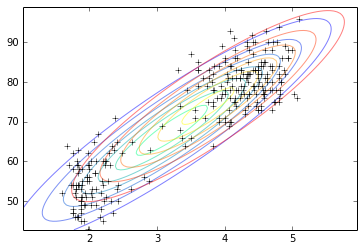

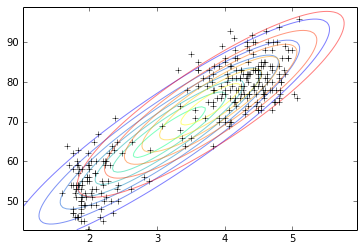

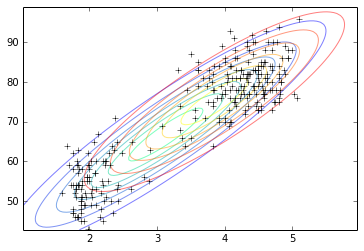

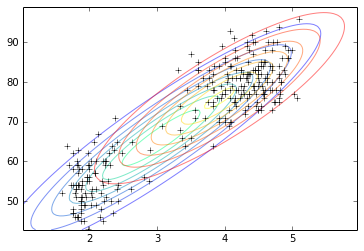

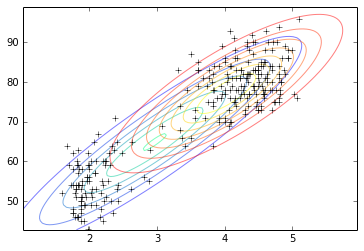

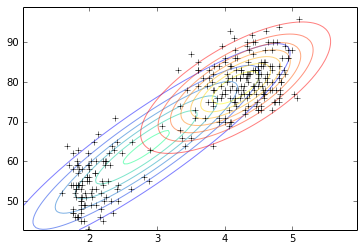

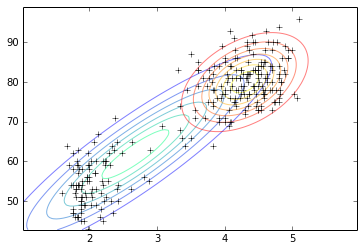

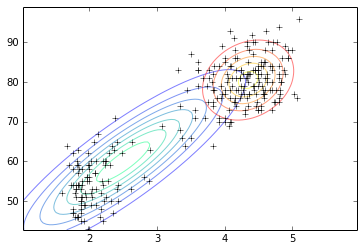

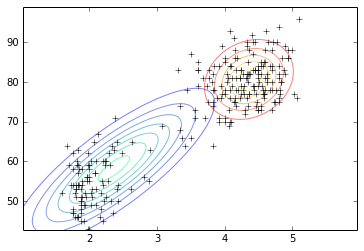

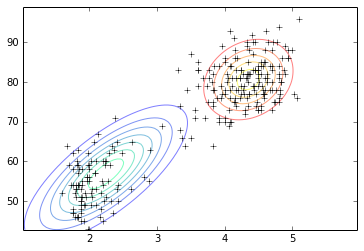

In [16]:
mean1 = data[:,0].mean ()
mean2 = data[:,1].mean ()
std1  = data[:,0].std ()
std2  = data[:,1].std ()
params = np.array ( [(mean1 - 0.2, mean2 - 1, std1, std2, 0),
                     (mean1 + 0.2, mean2 + 1, std1, std2, 0)] )
weights = np.array ( [ 0.5, 0.5 ] )

res_EM = []
for i in range(10):
    Q = Q_i ( data, params, weights )
    params, weights = M_step ( data, Q, params, weights )
    res_EM.append((params, weights))
    fig = plt.figure ()
    ax = fig.add_subplot(111)
    dessine_normales ( data, params, weights, bounds, ax )
    plt.show ()

## 8. Algorithme EM : version finale et animation

step animate = 0


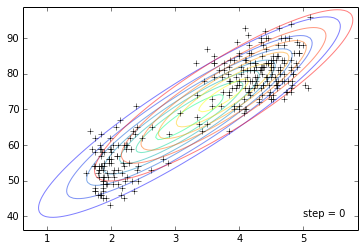

In [17]:
# calcul des bornes pour contenir toutes les lois normales calculées
def find_video_bounds ( data, res_EM ):
    bounds = np.asarray ( find_bounds ( data, res_EM[0][0] ) )
    for param in res_EM:
        new_bound = find_bounds ( data, param[0] )
        for i in [0,2]:
            bounds[i] = min ( bounds[i], new_bound[i] )
        for i in [1,3]:
            bounds[i] = max ( bounds[i], new_bound[i] )
    return bounds

bounds = find_video_bounds ( data, res_EM )


import matplotlib.animation as animation

# création de l'animation : tout d'abord on crée la figure qui sera animée
fig = plt.figure ()
ax = fig.gca (xlim=(bounds[0], bounds[1]), ylim=(bounds[2], bounds[3]))

# la fonction appelée à chaque pas de temps pour créer l'animation
def animate ( i ):
    ax.cla ()
    dessine_normales (data, res_EM[i][0], res_EM[i][1], bounds, ax)
    ax.text(5, 40, 'step = ' + str ( i ))
    print("step animate = %d" % ( i ))

# exécution de l'animation
anim = animation.FuncAnimation(fig, animate, 
                               frames = len ( res_EM ), interval=500 )
plt.show ()

# éventuellement, sauver l'animation dans une vidéo
# anim.save('old_faithful.avi', bitrate=4000)

## 9. K-Means Hard Assignment

In [18]:
def kmean(data, centroids, nb_iters=100):
    for i in range(nb_iters):
        distances = np.array([np.abs(data - c) for c in centroids]).sum(axis=2)
        clusters_labels = np.array([v.argmin() for v in np.array(list(zip(*distances)))])
        centroids = np.array([data[np.where(clusters_labels == lbl)].mean(axis=0) for lbl in set(clusters_labels)])
    return clusters_labels


In [19]:
centroids = np.array([[2, 55], [5, 80]])
lbl = kmean(data, centroids)

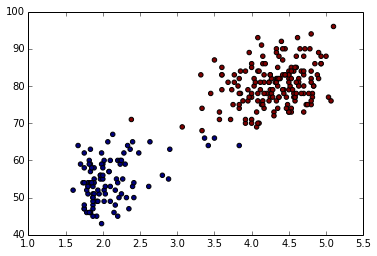

In [20]:
plt.scatter(*data.T, c=lbl)
plt.show()